In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import healpy as hp

import numpy as np

import tensorflow as tf

from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils

from tqdm import tqdm

### Advanced Tutorial

This notebook dives deeper into the functionality of DeepSphere for TF 2.x. In contains examples of:
- Creating a padded survey masked
- Training on masked data
- Custom training loops
- More layers that are included in the package

### 1 Data loading

The data consists of a toy dataset that is sufficiently small to have fun with. It is made of 200 maps of size `NSIDE=64` splitted into 2 classes. 

The maps contain a Gaussian random field realisations produced with Synfast function from Healpy package.
The input power spectra were taken from LambdaCDM model with two sets of parameters.
These maps are not realistic cosmological mass maps, just a toy dataset.
We downsampled them to `Nside=64` in order to make the processing faster.

In [2]:
data = np.load('../data/maps_downsampled_64.npz')
assert(len(data['class1']) == len(data['class2']))
nclass = len(data['class1'])

Let us plot a map of each class. It is not simple to visually catch the differences.

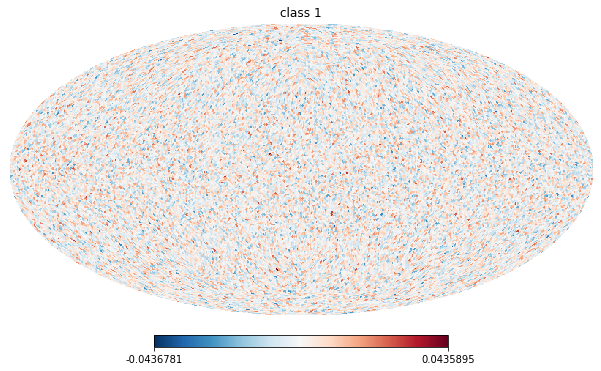

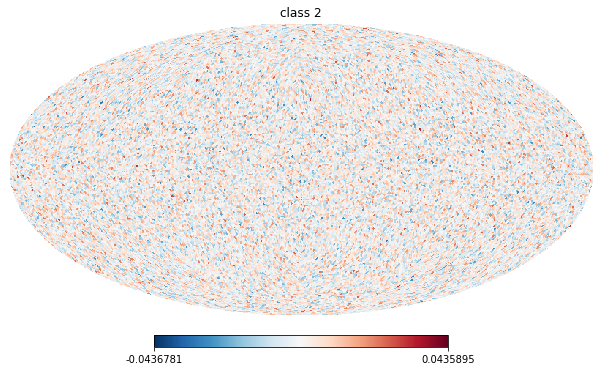

In [3]:
cmin = min(np.min(data['class1']), np.min(data['class2']))
cmax = max(np.max(data['class1']), np.max(data['class2']))
cm = plt.cm.RdBu_r
hp.mollview(data['class1'][0], title='class 1', nest=True, cmap=cm, min=cmin, max=cmax)
hp.mollview(data['class2'][0], title='class 2', nest=True, cmap=cm, min=cmin, max=cmax)

### 2 Survey mask creation and padding

Here we create a survey mask (usually this part is already pre-defined).

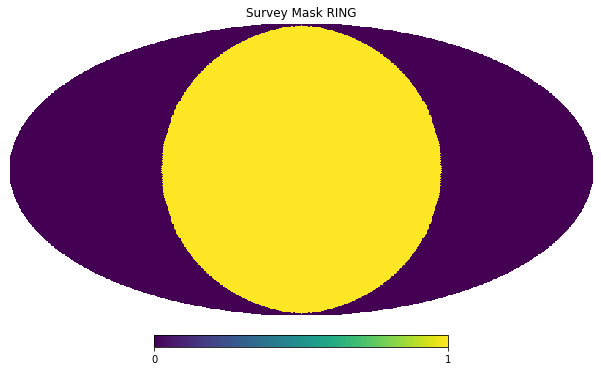

In [4]:
nside = 64
npix = hp.nside2npix(nside=nside)

relevant_pixel = hp.query_disc(nside=nside, vec=np.array([1.0, 0.0, 0.0]), radius=1.5)
boolian_mask = np.zeros(npix, dtype=np.bool)
boolian_mask[relevant_pixel] = 1

hp.mollview(boolian_mask, title="Survey Mask RING")

Note that every DeepSphere usually expects everything concerning `healpy` to be in `NEST` ordering. So we will reorder the mask right now.

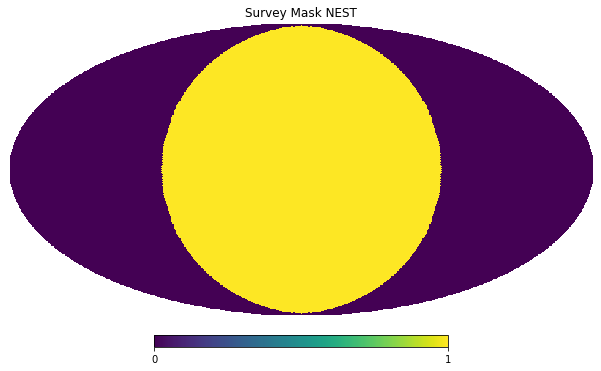

In [5]:
boolian_mask = hp.reorder(boolian_mask, r2n=True)
relevant_pixel = np.arange(npix)[boolian_mask]

hp.mollview(boolian_mask, title="Survey Mask NEST", nest=True)

During a forward pass one usually wants to downsample the input map using the hierarchical pixelization scheme of healpy and the appropriate layers of DeepSphere (see figure).

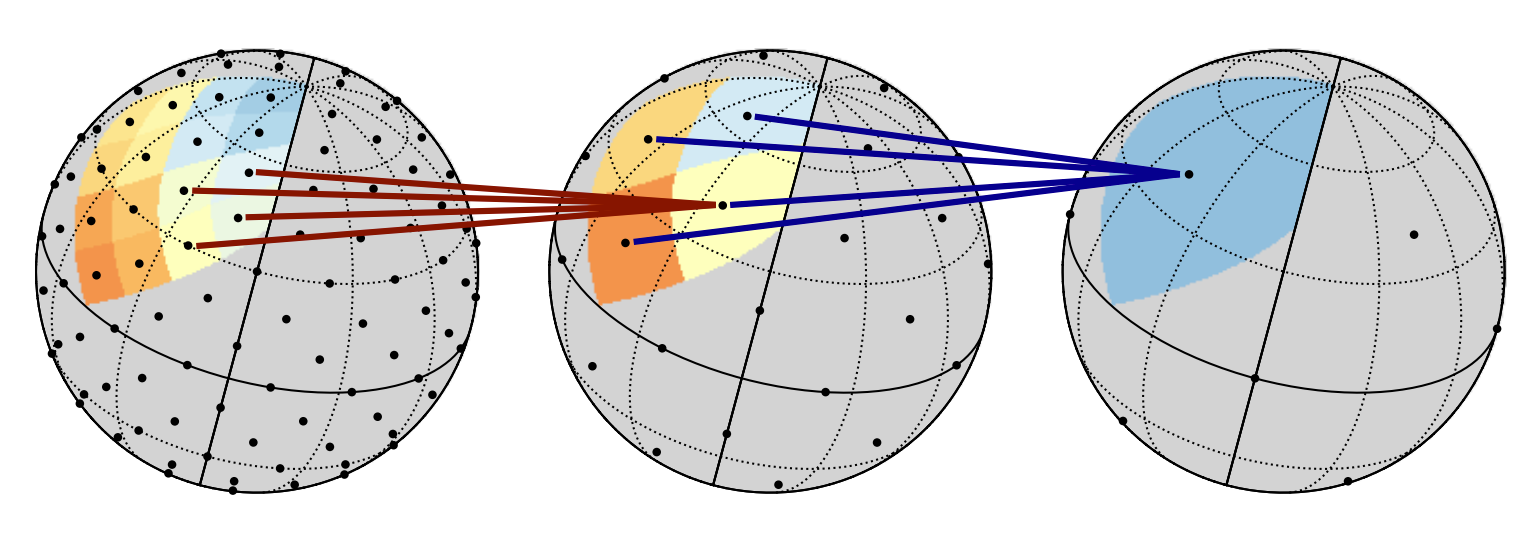

To make this possible, it is important that the survey mask includes all the relevant pixels, such one can downsample the map properly. To make this possible one can apply a padding to the original mask. DeepSphere includes a function to automatically find the relevant pixels for the padding.

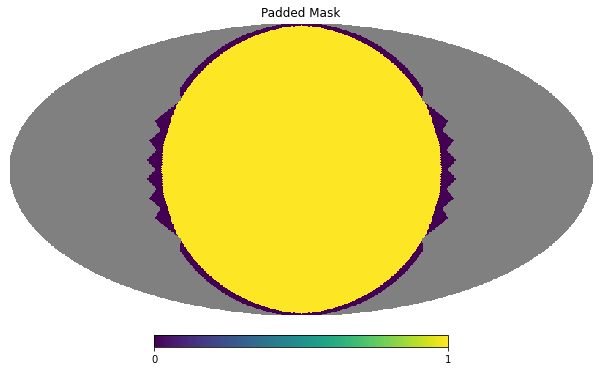

In [6]:
padded_pixel = utils.extend_indices(relevant_pixel, nside_in=nside, nside_out=8)

padded_mask = np.full(npix, hp.UNSEEN)
padded_mask[padded_pixel] = 0
padded_mask[relevant_pixel] = 1

hp.mollview(padded_mask, title="Padded Mask", nest=True)

### 3 Dataset creation

The masking and padding has to be done manually and will not be done by the network, mainly because of the efficiency. 

In [7]:
x_raw = np.concatenate([data["class1"], data["class2"]]).astype(np.float32)
labels = np.concatenate([np.zeros(nclass), np.ones(nclass)]).astype(np.float32)

x_pad = []
temp_map = np.zeros(npix)
for sample in x_raw:
    temp_map[relevant_pixel] = sample[relevant_pixel]
    x_pad.append(temp_map[padded_pixel])
x_pad = np.array(x_pad)[...,None]

We shuffle the data and split it into test and train data

In [8]:
np.random.seed(11)
np.random.shuffle(x_pad)
np.random.seed(11)
np.random.shuffle(labels)

x_train, x_test = np.split(x_pad, indices_or_sections=[160])
y_train, y_test = np.split(labels, indices_or_sections=[160])

We create a tensorflow dataset

In [9]:
dset_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_test),
                                 tf.data.Dataset.from_tensor_slices(y_test)))
dset_test = dset_test.batch(16)

dset_train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train),
                                  tf.data.Dataset.from_tensor_slices(y_train)))
dset_train = dset_train.shuffle(160)                                 
dset_train = dset_train.batch(16)

### 4 Building the Model

Here we will define a network and train it such that it can correctly classifiy the two classes of maps. We start by defining the layers we want to use. The `HealpyGCNN` class is a subclass from `tf.keras.Sequential`, meaning we can use a lot of the already existing TF functionality and can even interlace normal layers with our graph convolution if we want to.

Below we give an example of most of the layers implemented in DeepSphere. To learn more about each layer use the `help()` or `?` function.

In [10]:
layers = [# this is a graph convolutional layer, it preserves the shape of the input
          hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          # max pooling, it reduces the nside by 4**p
          hp_layer.HealpyPool(p=1, pool_type="MAX"),
          # another graph convolutional layer, it preserves the shape of the input
          hp_layer.HealpyMonomial(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          # average pooling, it reduces the nside by 4**p
          hp_layer.HealpyPool(p=1, pool_type="AVG"),
          # a residual layer using graph convolutions
          hp_layer.Healpy_ResidualLayer(layer_type="CHEBY", 
                                        layer_kwargs={"K": 10, "activation": "relu",
                                                      "use_bn": True, "use_bias": True},
                                        use_bn=False,
                                        activation="relu", alpha=0.1),
          # This layer reduces the nside by 4**p using learnable weights
          hp_layer.HealpyPseudoConv(Fout=2, p=1, activation="relu"),
          # we can interlace DeepSphere layer with any keras layer
          # note that you need to take care of the output shape yourself
          # if you want to follow with graph convolutions
          tf.keras.layers.Lambda(lambda x: tf.nn.softmax(tf.reduce_mean(x, axis=1),
                                                         axis=-1))]

Noe we are ready to create the model

In [11]:
tf.keras.backend.clear_session()
model = HealpyGCNN(nside=nside, indices=padded_pixel, layers=layers)
model.build(input_shape=(None, len(padded_pixel), 1))
model.summary(110)

Detected a reduction factor of 8.0, the input with nside 64 will be transformed to 8 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_1"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
chebyshev (Chebyshev)                            (None, 24832, 5)                            65               
______________________________________________________________________________________________________________
healpy_pool (HealpyPool)                         (None, 6208, 5)                             0                
______________________________________________________________________________________________________________
monomial (Monomial)                              (None, 6208, 5)                             265              
________________________

### 5 Custom Training

The model itself is callable and there is no need for a session in TF 2.x.

In [12]:
for sample, label in dset_test.take(1):
    output = model(sample)
print(output)

tf.Tensor(
[[0.40066376 0.5993362 ]
 [0.4006701  0.5993299 ]
 [0.40063533 0.59936464]
 [0.4006726  0.5993274 ]
 [0.40068093 0.5993191 ]
 [0.40063682 0.5993632 ]
 [0.40061656 0.5993834 ]
 [0.400631   0.599369  ]
 [0.4006442  0.59935576]
 [0.40066773 0.5993323 ]
 [0.40062305 0.5993769 ]
 [0.40063053 0.5993694 ]
 [0.40066025 0.5993398 ]
 [0.40068203 0.59931797]
 [0.40067184 0.59932816]
 [0.4006637  0.59933627]], shape=(16, 2), dtype=float32)


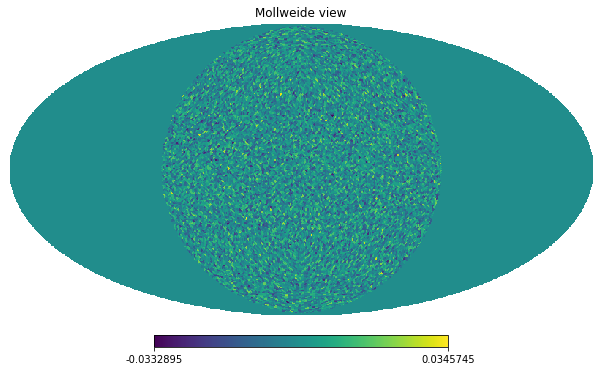

In [13]:
test_map = np.zeros(npix)
test_map[padded_pixel] = sample.numpy()[0,:,0]
hp.mollview(test_map, nest=True)

We define an optimizer and a loss function

In [14]:
optimizer = tf.keras.optimizers.Adam(0.1)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

Wrapping the training step into a `@tf.function()` decorator leads to a significant performance boost. Note that it is very important to pass the `training=True` argument to the model during training, as layers like batch normalization behave differently during training and evaluation.

In [15]:
@tf.function()
def train_step(samples, labels):
    with tf.GradientTape() as tape:
        loss_val = loss(y_pred=model(samples, training=True), y_true=labels)
    gradients = gradients = tape.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_val

We train the network for a few epochs

In [16]:
n_epochs = 50
for epoch in range(n_epochs):
    print(f"Starting with epoch {epoch + 1}/{n_epochs}", flush=True)
    with tqdm(dset_train, total=dset_train.cardinality().numpy()) as pbar:
        for samples, labels in pbar:
            loss_val = train_step(samples, labels)
            pbar.set_postfix(loss_val=loss_val.numpy(), refresh=False)
        for samples, labels in dset_test:
            predictions = model(samples, training=False)
            accuracy.update_state(y_true=labels, y_pred=predictions)
        print(f"Validation accuracy: {accuracy.result()}")

Starting with epoch 1/50


100%|██████████| 10/10 [00:04<00:00,  2.42it/s, loss_val=0.054]


Validation accuracy: 0.4749999940395355
Starting with epoch 2/50


100%|██████████| 10/10 [00:02<00:00,  4.72it/s, loss_val=0.00461]


Validation accuracy: 0.4749999940395355
Starting with epoch 3/50


100%|██████████| 10/10 [00:02<00:00,  4.56it/s, loss_val=9.21e-5]


Validation accuracy: 0.4749999940395355
Starting with epoch 4/50


100%|██████████| 10/10 [00:02<00:00,  4.27it/s, loss_val=0.000185]


Validation accuracy: 0.4749999940395355
Starting with epoch 5/50


100%|██████████| 10/10 [00:02<00:00,  4.46it/s, loss_val=5.82e-5]


Validation accuracy: 0.4749999940395355
Starting with epoch 6/50


100%|██████████| 10/10 [00:02<00:00,  4.44it/s, loss_val=4.21e-5]


Validation accuracy: 0.4749999940395355
Starting with epoch 7/50


100%|██████████| 10/10 [00:02<00:00,  4.49it/s, loss_val=0.000544]


Validation accuracy: 0.4749999940395355
Starting with epoch 8/50


100%|██████████| 10/10 [00:02<00:00,  4.50it/s, loss_val=4.64e-5]


Validation accuracy: 0.48124998807907104
Starting with epoch 9/50


100%|██████████| 10/10 [00:02<00:00,  4.47it/s, loss_val=3.81e-5]


Validation accuracy: 0.4861111044883728
Starting with epoch 10/50


100%|██████████| 10/10 [00:02<00:00,  4.25it/s, loss_val=0.000477]


Validation accuracy: 0.5325000286102295
Starting with epoch 11/50


100%|██████████| 10/10 [00:02<00:00,  4.07it/s, loss_val=0.000135]


Validation accuracy: 0.574999988079071
Starting with epoch 12/50


100%|██████████| 10/10 [00:02<00:00,  4.37it/s, loss_val=6.69e-5]


Validation accuracy: 0.6104166507720947
Starting with epoch 13/50


100%|██████████| 10/10 [00:02<00:00,  4.53it/s, loss_val=1.77e-5]


Validation accuracy: 0.6403846144676208
Starting with epoch 14/50


100%|██████████| 10/10 [00:02<00:00,  4.08it/s, loss_val=1.99e-5]


Validation accuracy: 0.6660714149475098
Starting with epoch 15/50


100%|██████████| 10/10 [00:02<00:00,  4.45it/s, loss_val=0.000192]


Validation accuracy: 0.6883333325386047
Starting with epoch 16/50


100%|██████████| 10/10 [00:02<00:00,  4.44it/s, loss_val=3.32e-5]


Validation accuracy: 0.707812488079071
Starting with epoch 17/50


100%|██████████| 10/10 [00:02<00:00,  4.30it/s, loss_val=0.0023] 


Validation accuracy: 0.7250000238418579
Starting with epoch 18/50


100%|██████████| 10/10 [00:02<00:00,  4.53it/s, loss_val=1.06e-5]


Validation accuracy: 0.7402777671813965
Starting with epoch 19/50


100%|██████████| 10/10 [00:02<00:00,  4.31it/s, loss_val=5.61e-5]


Validation accuracy: 0.753947377204895
Starting with epoch 20/50


100%|██████████| 10/10 [00:02<00:00,  4.34it/s, loss_val=8.82e-5]


Validation accuracy: 0.7662500143051147
Starting with epoch 21/50


100%|██████████| 10/10 [00:02<00:00,  4.41it/s, loss_val=0.0272] 


Validation accuracy: 0.761904776096344
Starting with epoch 22/50


100%|██████████| 10/10 [00:02<00:00,  4.55it/s, loss_val=0.0382] 


Validation accuracy: 0.7727272510528564
Starting with epoch 23/50


100%|██████████| 10/10 [00:02<00:00,  4.35it/s, loss_val=2.37e-5]


Validation accuracy: 0.759782612323761
Starting with epoch 24/50


100%|██████████| 10/10 [00:02<00:00,  4.52it/s, loss_val=0.000947]


Validation accuracy: 0.7479166388511658
Starting with epoch 25/50


100%|██████████| 10/10 [00:02<00:00,  4.48it/s, loss_val=0.000307]


Validation accuracy: 0.7549999952316284
Starting with epoch 26/50


100%|██████████| 10/10 [00:02<00:00,  4.41it/s, loss_val=0.000111]


Validation accuracy: 0.7644230723381042
Starting with epoch 27/50


100%|██████████| 10/10 [00:02<00:00,  3.65it/s, loss_val=2.24e-5]


Validation accuracy: 0.7731481194496155
Starting with epoch 28/50


100%|██████████| 10/10 [00:02<00:00,  3.39it/s, loss_val=3.94e-5]


Validation accuracy: 0.78125
Starting with epoch 29/50


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss_val=1.89e-5]


Validation accuracy: 0.7887930870056152
Starting with epoch 30/50


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss_val=3.93e-6]


Validation accuracy: 0.7958333492279053
Starting with epoch 31/50


100%|██████████| 10/10 [00:02<00:00,  4.38it/s, loss_val=2.36e-5]


Validation accuracy: 0.8024193644523621
Starting with epoch 32/50


100%|██████████| 10/10 [00:02<00:00,  4.62it/s, loss_val=4.09e-5]


Validation accuracy: 0.80859375
Starting with epoch 33/50


100%|██████████| 10/10 [00:02<00:00,  4.45it/s, loss_val=1.55e-5]


Validation accuracy: 0.814393937587738
Starting with epoch 34/50


100%|██████████| 10/10 [00:02<00:00,  4.18it/s, loss_val=4.51e-6]


Validation accuracy: 0.8198529481887817
Starting with epoch 35/50


100%|██████████| 10/10 [00:02<00:00,  4.44it/s, loss_val=0.000121]


Validation accuracy: 0.824999988079071
Starting with epoch 36/50


100%|██████████| 10/10 [00:02<00:00,  4.26it/s, loss_val=2.53e-6]


Validation accuracy: 0.8298611044883728
Starting with epoch 37/50


100%|██████████| 10/10 [00:02<00:00,  4.86it/s, loss_val=4.31e-6]


Validation accuracy: 0.8344594836235046
Starting with epoch 38/50


100%|██████████| 10/10 [00:02<00:00,  4.40it/s, loss_val=1.91e-6]


Validation accuracy: 0.8388158082962036
Starting with epoch 39/50


100%|██████████| 10/10 [00:02<00:00,  4.47it/s, loss_val=1.87e-6]


Validation accuracy: 0.8429487347602844
Starting with epoch 40/50


100%|██████████| 10/10 [00:02<00:00,  4.46it/s, loss_val=7.35e-5]


Validation accuracy: 0.846875011920929
Starting with epoch 41/50


100%|██████████| 10/10 [00:02<00:00,  4.56it/s, loss_val=1.66e-6]


Validation accuracy: 0.8506097793579102
Starting with epoch 42/50


100%|██████████| 10/10 [00:02<00:00,  4.28it/s, loss_val=1.88e-6]


Validation accuracy: 0.8541666865348816
Starting with epoch 43/50


100%|██████████| 10/10 [00:01<00:00,  5.31it/s, loss_val=6.85e-5]


Validation accuracy: 0.8465116024017334
Starting with epoch 44/50


100%|██████████| 10/10 [00:02<00:00,  4.07it/s, loss_val=8.64e-7]


Validation accuracy: 0.8380681872367859
Starting with epoch 45/50


100%|██████████| 10/10 [00:02<00:00,  4.10it/s, loss_val=9.83e-7]


Validation accuracy: 0.8311111330986023
Starting with epoch 46/50


100%|██████████| 10/10 [00:02<00:00,  4.25it/s, loss_val=0.00121]


Validation accuracy: 0.824456512928009
Starting with epoch 47/50


100%|██████████| 10/10 [00:02<00:00,  4.23it/s, loss_val=1.22e-6]


Validation accuracy: 0.8281915187835693
Starting with epoch 48/50


100%|██████████| 10/10 [00:02<00:00,  4.62it/s, loss_val=2.7e-6] 


Validation accuracy: 0.8317708373069763
Starting with epoch 49/50


100%|██████████| 10/10 [00:02<00:00,  4.66it/s, loss_val=8.72e-7]


Validation accuracy: 0.8352040648460388
Starting with epoch 50/50


100%|██████████| 10/10 [00:02<00:00,  4.25it/s, loss_val=5.81e-7]


Validation accuracy: 0.8385000228881836


If we want to do actual predictions, we just call the model again.

In [17]:
for sample, label in dset_test.take(1):
    output = model(sample)
print("Raw output: ", output)
print("Class output: ", tf.argmax(output, axis=1))
print("Correct classification: ", tf.argmax(output, axis=1) == tf.cast(label, tf.int64))

Raw output:  tf.Tensor(
[[2.1475682e-06 9.9999785e-01]
 [7.2402230e-07 9.9999928e-01]
 [1.0000000e+00 1.7847199e-08]
 [1.1393221e-05 9.9998856e-01]
 [1.8328010e-06 9.9999821e-01]
 [1.0000000e+00 8.3858209e-09]
 [1.0000000e+00 2.0101886e-08]
 [1.0000000e+00 5.4133661e-08]
 [4.7119242e-06 9.9999523e-01]
 [1.2593896e-05 9.9998736e-01]
 [1.0000000e+00 4.0070871e-09]
 [9.9999988e-01 6.6520158e-08]
 [3.4681481e-05 9.9996531e-01]
 [9.1694636e-07 9.9999905e-01]
 [9.9618671e-07 9.9999905e-01]
 [5.0379117e-06 9.9999499e-01]], shape=(16, 2), dtype=float32)
Class output:  tf.Tensor([1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1], shape=(16,), dtype=int64)
Correct classification:  tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True], shape=(16,), dtype=bool)


### 5 Filter Visualization

We observe the Chebyshef polynomial, i.e the filters in the graph spectral domain. This visuallization can help to understand wich graph frequencies are picked by the filtering operation. It mostly interpretable by the people for the graph signal processing community.

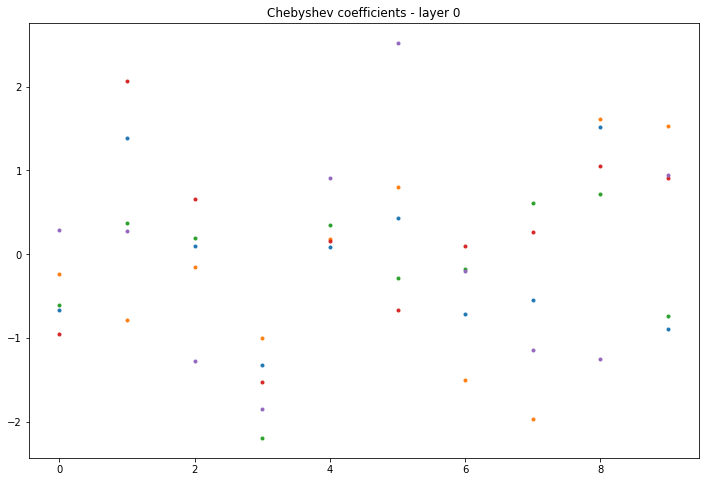

In [18]:
layer=0
plt.figure(figsize=(12,8))
model.plot_chebyshev_coeffs(layer)

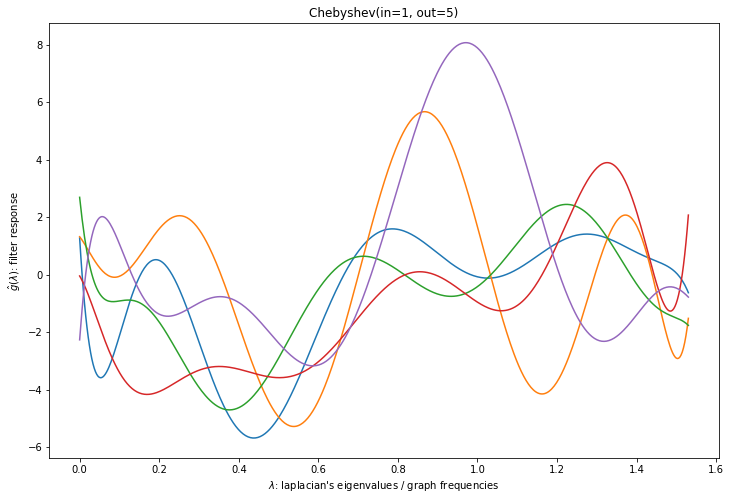

In [19]:
plt.figure(figsize=(12,8))
model.plot_filters_spectral(layer)

Here comes one of the most human friendly representation of the filters. It consists the section of the filters "projected" on the sphere. Because of the irregularity of the healpix sampling, this representation of the filters may not look very smooth.

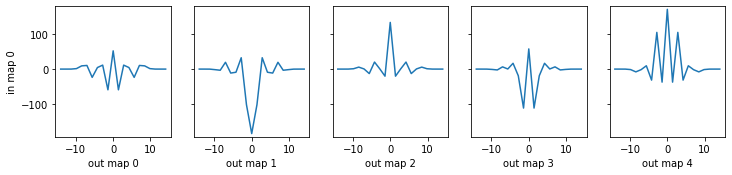

In [20]:
model.plot_filters_section(layer, title='');

Eventually, we can simply look at the filters on sphere. This representation clearly displays the sampling artifacts.

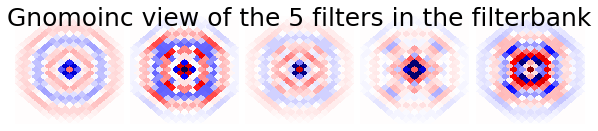

In [21]:
figs = model.plot_filters_gnomonic(layer, title=None)